In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import collections
sys.path.append('../../')
import numpy as np
import os
import re
import collections
import time 
import gzip
from utils import utils
import json 
import csv
import pandas as pd
import tabix

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = rsid.split("_")[0][3:]
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import operator
json_file = "../../gtex_v8_metadata.json"
tissue_file = "../../plots/tissue_table.txt"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tstring in zip(tshorts, tstrings):
    tissue_names[tshort] = tstring
        
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]
#select_tissues = ['ms', 'wb', 'sse', 'as', 'hlv', 'colt', 'bco', 'aa', 'ag' , 'ac', 'bca', 'ac', 'fib', 'bceh', 'bhi', 'tes', 'nt', 'thy']


In [5]:
expr = "raw"
preproc = "permnull_sb0.1_knn30"

basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/"
trans_dict = dict()
sumdir = os.path.join(basepath, expr, "summary_5e-08")
for tissue in tshorts:
    tejaas_file = os.path.join(sumdir, tissue, "tejaas", preproc, "trans_eqtls.txt.ld_prune")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue)
    transeqtls = tejaas(tejaas_file)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
    else:
        trans_dict[tissue] = []
        print("{:s} has 0 trans-eqtls".format(tissue))

Loading  as
Loading  av
Loading  ag
Loading  aa
Loading  ac
Loading  at
Loading  bl
Loading  bam
Loading  ban
Loading  bca
Loading  bceh
Loading  bce
Loading  bco
Loading  bfr
Loading  bhi
Loading  bhy
Loading  bnu
Loading  bpu
Loading  bsp
Loading  bsu
Loading  br
Loading  ebv
Loading  fib
Loading  cols
Loading  colt
Loading  esog
Loading  esom
Loading  esomu
Loading  haa
haa has 0 trans-eqtls
Loading  hlv
Loading  kc
Loading  liv
Loading  lu
Loading  msg
Loading  ms
Loading  nt
Loading  ov
Loading  pan
pan has 0 trans-eqtls
Loading  pit
Loading  pro
Loading  snse
Loading  sse
Loading  si
Loading  spl
Loading  sto
Loading  tes
Loading  thy
Loading  ut
Loading  va
va has 0 trans-eqtls
Loading  wb
wb has 0 trans-eqtls


## Reading in GWAS pval arrays

In [6]:
def read_gwas_result(filepath, trans_dict = None, tissue = None):
    rsids = list()
    studies = collections.defaultdict(list)
    matrix = list()
    with open(filepath) as instream:
        header = instream.readline().strip().split("\t")
        study_names = header[1:]
        for line in instream:
            arr = line.strip().split("\t")
            rsid = arr[0]
            # Filtering out only those that are in the dictionary
            if trans_dict:
                if rsid in trans_dict[tissue]:
                    values = np.array([float(x) for x in arr[1:]])
                    #values[values < 1e-100] = np.nan
                    values[values == 0] = np.nan
                    rsids.append(rsid)
                    matrix.append(values)
            # Otherwise reading all entries
            else:
                values = np.array([float(x) for x in arr[1:]])
                values[values == 0] = np.nan
                rsids.append(rsid)
                matrix.append(values)
    if len(matrix) > 0:
        matrix = np.array(matrix)
        for i, study in enumerate(study_names):
            studies[study] = matrix[:,i]
    return rsids, matrix, studies


def read_gwas_result(filepath):
    rsids = list()
    studies = collections.defaultdict(list)
    matrix = list()
    with open(filepath) as instream:
        header = instream.readline().strip().split("\t")
        study_names = header[1:]
        for line in instream:
            arr = line.strip().split("\t")
            rsid = arr[0]
            values = np.array([float(x) for x in arr[1:]])
            #values[values < 1e-100] = np.nan
            values[values == 0] = np.nan
            rsids.append(rsid)
            matrix.append(values)
    if len(matrix) > 0:
        matrix = np.array(matrix)
        for i,st in enumerate(study_names):
            studies[st] = matrix[:,i]
    return rsids, matrix, studies

In [7]:
def get_study_pvals(variant_ids, tb):
    pvals = np.full((len(variant_ids)), np.nan)
    variant_counter = 0
    for variant_id in variant_ids:
        chrom = variant_id.split("_")[0]
        pos = variant_id.split("_")[1]
        response = tb.querys(chrom + ":" + pos + "-" + pos)
        response = list(response)
        if len(response) > 1:
            print(response)
            raise
        if len(response) > 0:
            pval = response[0][10]
            if pval != 'NA':
                pvals[variant_counter] = pval
        variant_counter += 1
    return pvals

def get_array_all_pvals(filepaths, variant_ids):
    # Array with all variant_ids as rows and pvals for all of the 87 studies in the following columns
    all_pvals = np.zeros((len(variant_ids), len(filepaths)))
    all_pvals.fill(np.nan)
    # TODO: name columns
    file_counter = 0
    for filepath in filepaths:
        tb = tabix.open(filepath)
        study_pvals = np.array((len(variant_ids), 1))
        variant_counter = 0
        all_pvals[:, file_counter] = get_study_pvals(variant_ids, tb)
        file_counter += 1
    return all_pvals

In [8]:
gwas_basepath = "/cbscratch/franco/datasets/GWAS_GTEx_v8/"
df_metadata = pd.read_csv(gwas_basepath + "gwas_metadata.txt", header=0, sep="\t")
study_catg = dict(zip("imputed_"+df_metadata.Tag, df_metadata.Category))
study_abbr = dict(zip("imputed_"+df_metadata.Tag, df_metadata.new_abbreviation))
study_name = dict(zip("imputed_"+df_metadata.Tag, df_metadata.new_Phenotype))

In [11]:
studies = list(study_abbr.keys())
filepaths = [os.path.join(gwas_basepath,"relevant", studie + ".txt.gz") for studie in studies]
filepaths = [ x for x in filepaths if os.path.exists(x)]
relevant_studies = [study for study in studies if os.path.exists(gwas_basepath + study + ".txt.gz")]


In [15]:
mytissue = "ac"
variants = [x.rsid for x in trans_dict[mytissue]]
st = time.time()
pval_res = get_array_all_pvals(filepaths, variants)
endt = time.time()
print("Took {:f}".format(endt-st))

Took 29.304800


In [25]:
# ##### Read in list of all SNPs and sample from them
# ##### Don't rerun!
# def read_snplist(filename, mafcutoff=0.01):
#     rsidlist = list()
#     maflist  = list()
#     with open(filename) as instream:
#         next(instream)
#         for line in instream:
#             arr  = line.strip().split("\t")
#             rsid = arr[0]
#             maf  = float(arr[1])
#             if maf >= mafcutoff and maf <= (1 - mafcutoff) :
#                 rsidlist.append(rsid)
#                 maflist.append(maf)
#     return rsidlist, maflist

# snpsfilefmt = f"{basepath}/raw/summary_5e-08/aa/tejaas/{preproc}/snps_list.txt"
# snps_list, maf_list = read_snplist(snpsfilefmt)

# nchoose = 20000
# chooseidx = np.sort(np.random.choice(len(snps_list), nchoose, replace = False))
# rand_variants = [snps_list[i] for i in chooseidx]

# st = time.time()
# rand_pval_res = get_array_all_pvals(filepaths, rand_variants)
# endt = time.time()
# print("Took {:f}".format(endt-st))

# # Write rand output for all studies (SNPs x Studies)
# df_rand = pd.DataFrame(rand_pval_res, columns = relevant_studies, index=rand_variants)
# df_rand.index.name = "gwas_studies"
# df_rand.to_csv("/media/disk1/gtex_v8/GWAS_rand_sampled.txt", sep="\t", header=True, index=True, na_rep="NULL")

Took 450.828233


In [20]:
df_rand = pd.read_csv("/cbscratch/franco/datasets/GWAS_GTEx_v8/relevant/GWAS_rand_sampled.txt", header=0, index_col=0, sep="\t")
df_rand.shape

(20000, 87)

In [22]:
# check nan SNPs
missings = np.all(df_rand.isna(), axis=1)
df_rand = df_rand[~missings]
# print(np.sum(np.all(df_rand.isna(), axis=1)))
df_rand.shape

(16371, 87)

In [61]:
import numbers 
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    # x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    # y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)
    x_quantiles = np.percentile(x, 100*quantiles, interpolation=interpolation)
    y_quantiles = np.percentile(y, 100*quantiles, interpolation=interpolation)

    
    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot([0,1],[0,1], color='red')

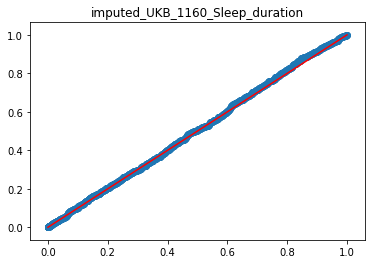

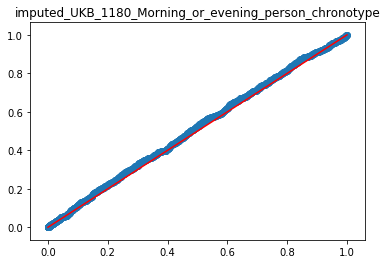

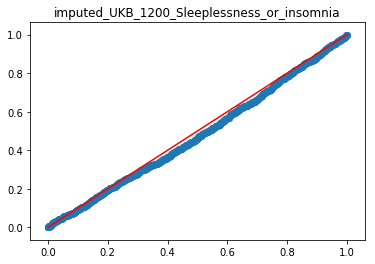

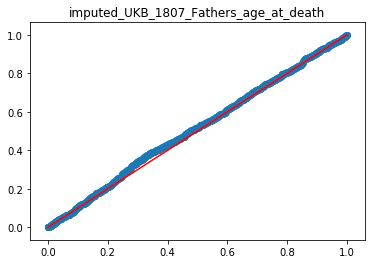

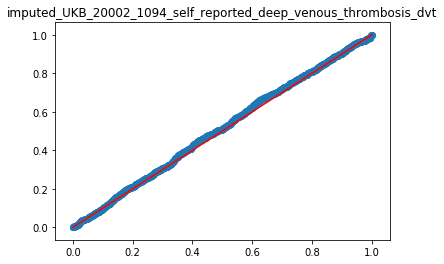

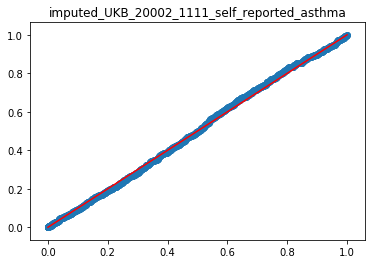

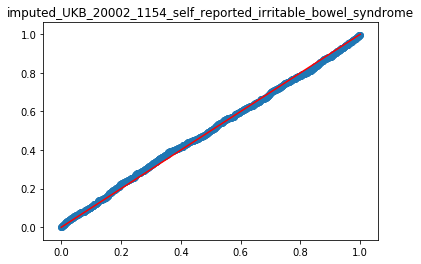

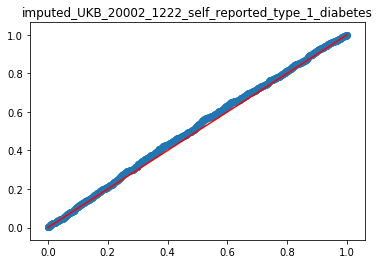

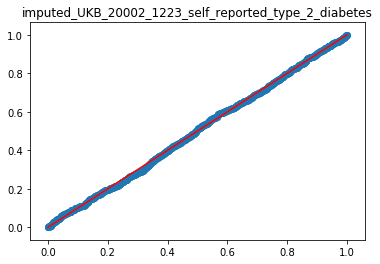

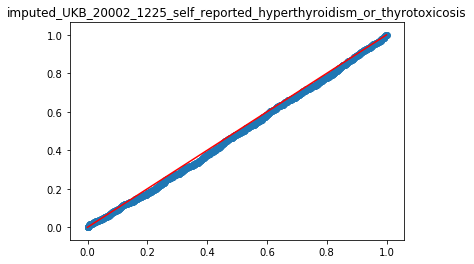

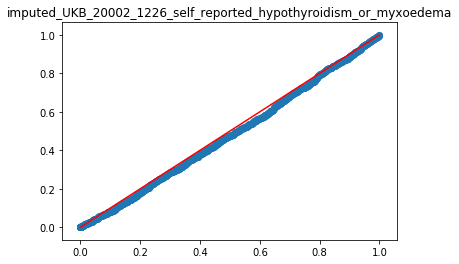

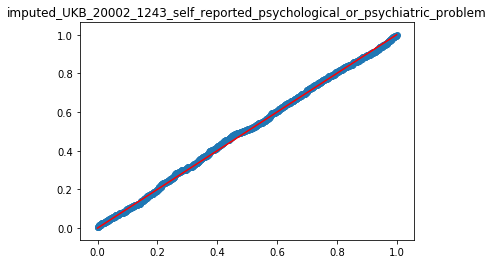

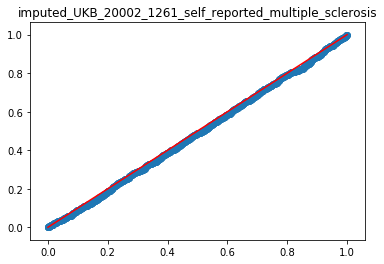

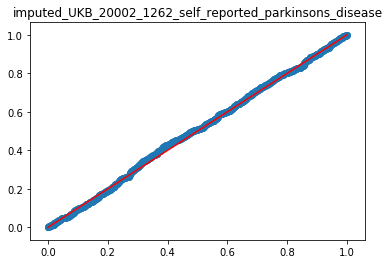

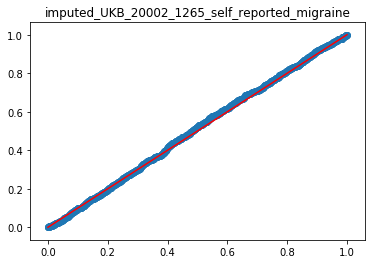

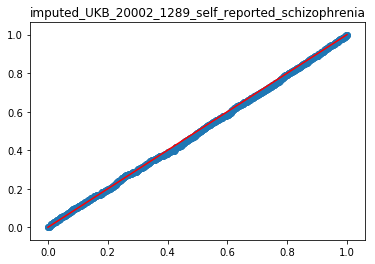

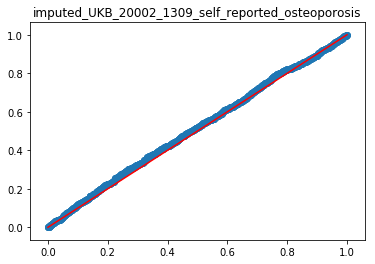

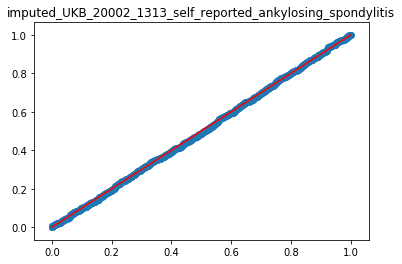

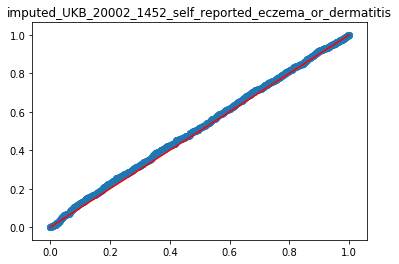

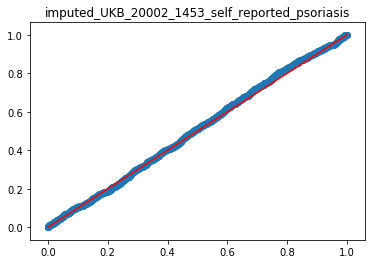

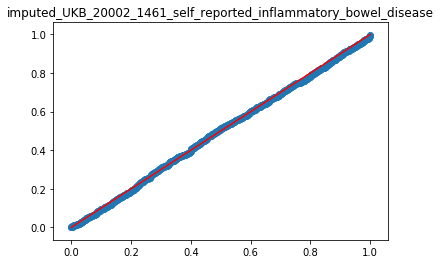

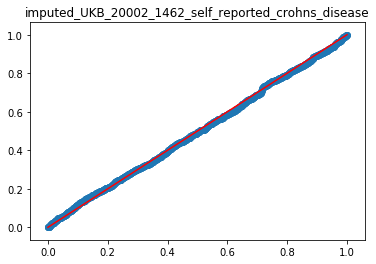

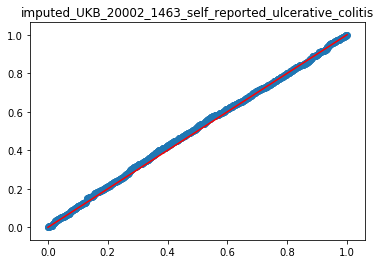

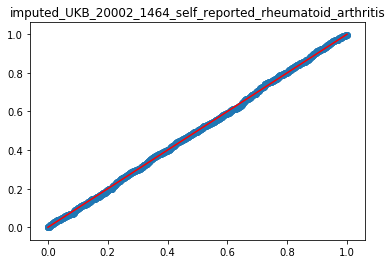

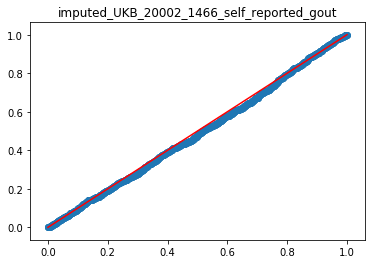

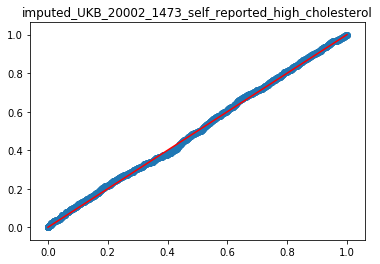

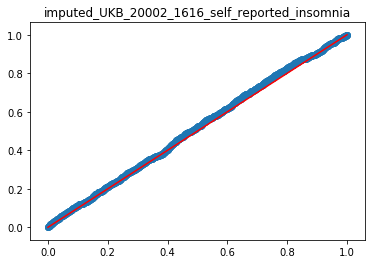

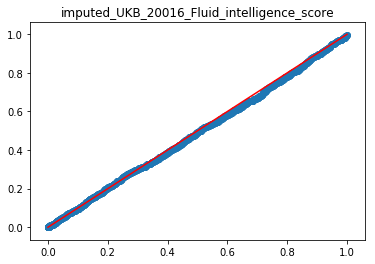

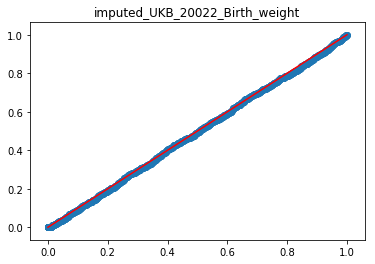

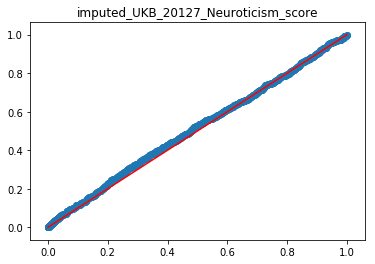

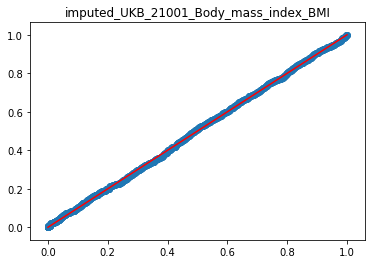

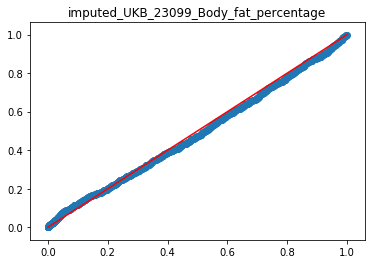

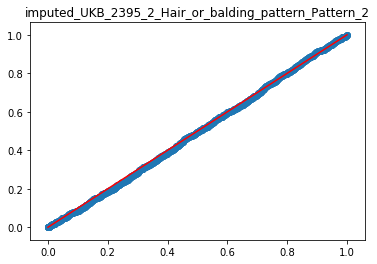

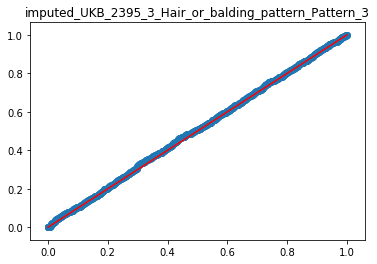

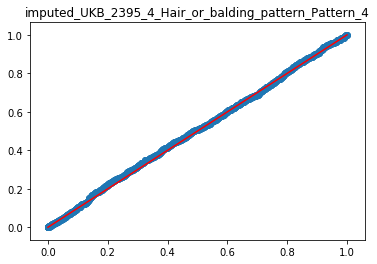

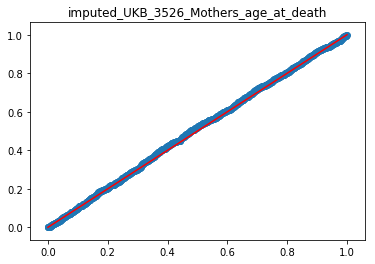

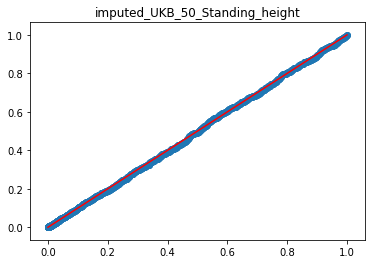

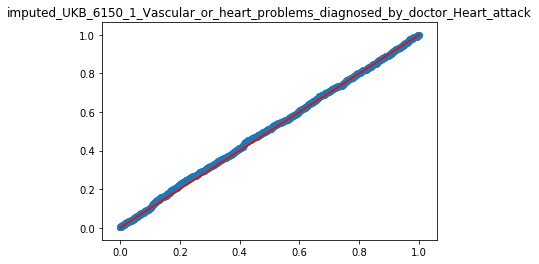

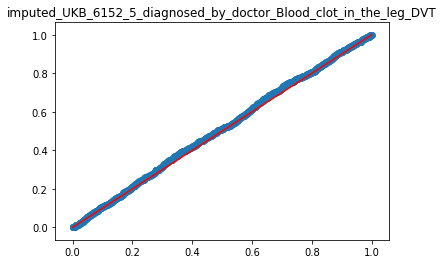

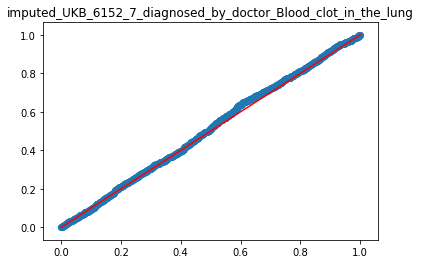

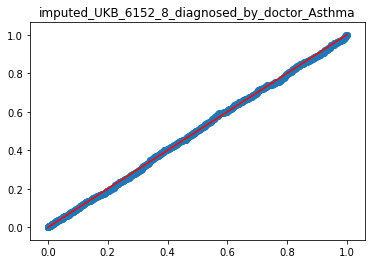

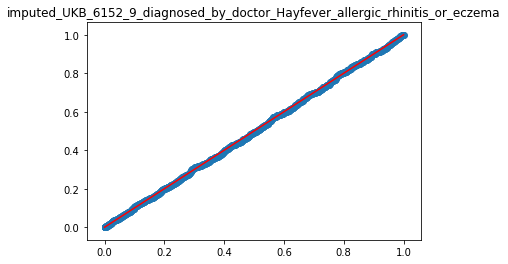

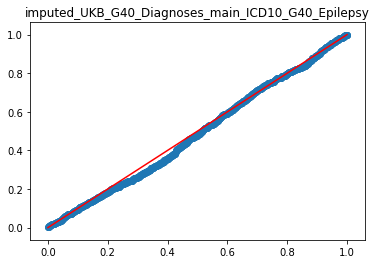

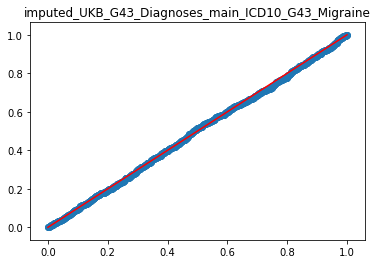

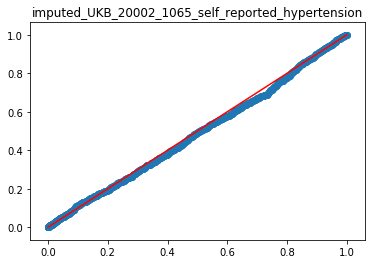

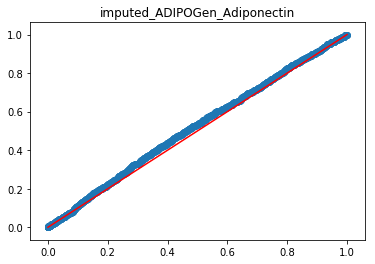

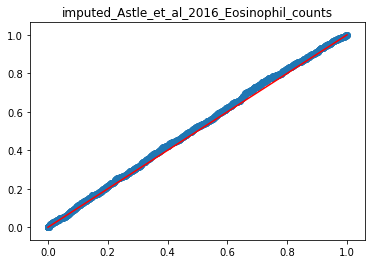

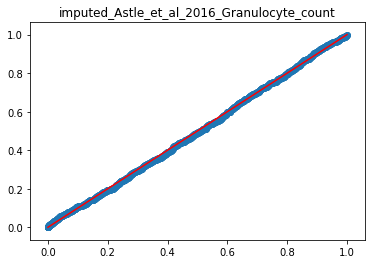

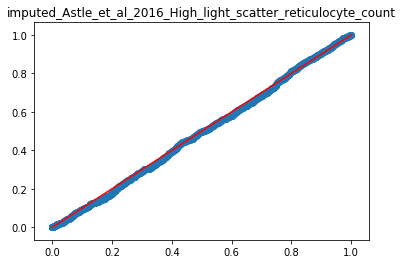

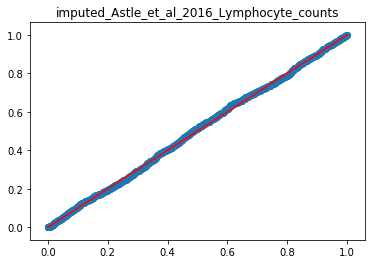

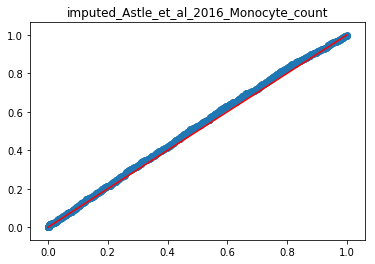

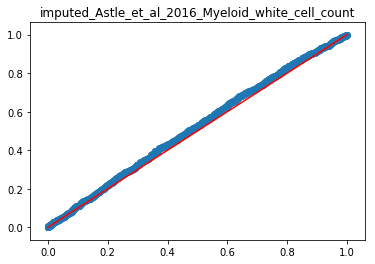

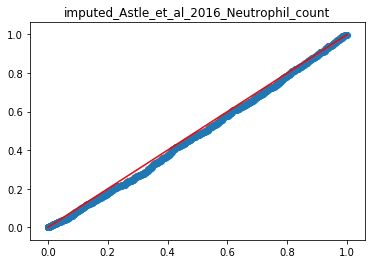

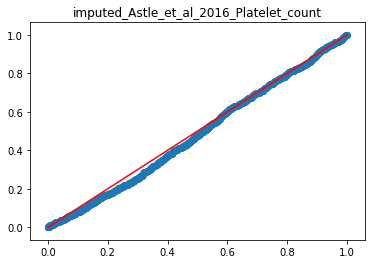

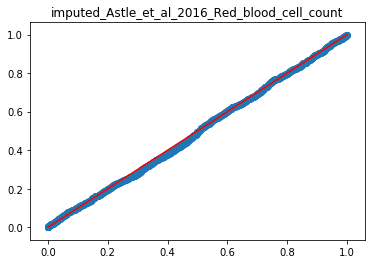

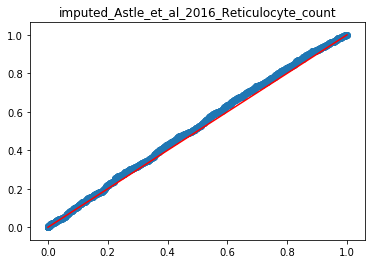

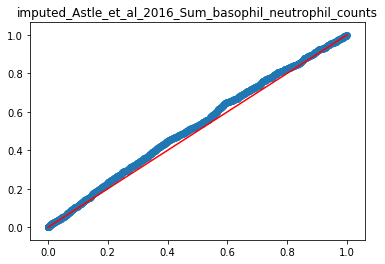

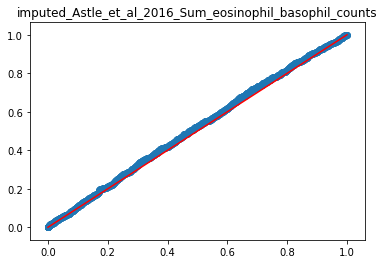

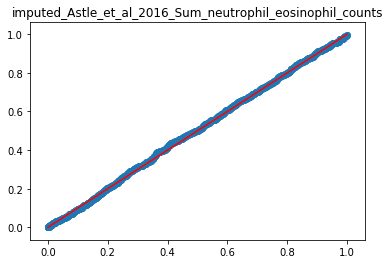

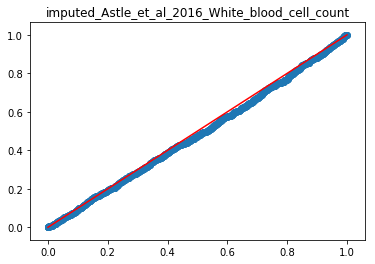

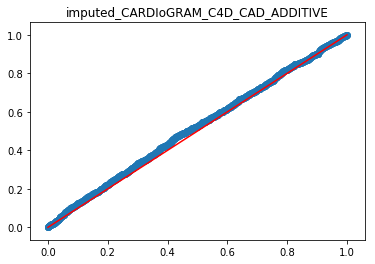

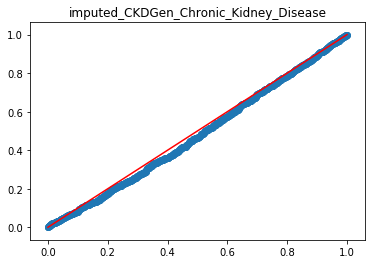

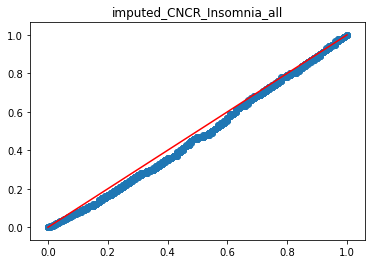

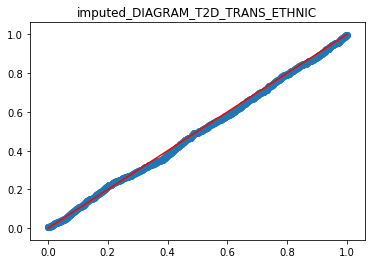

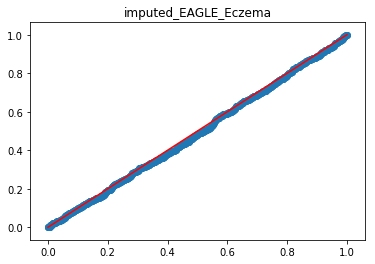

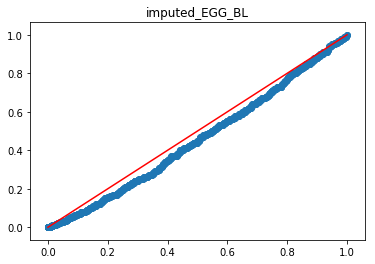

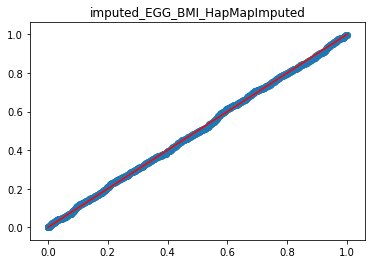

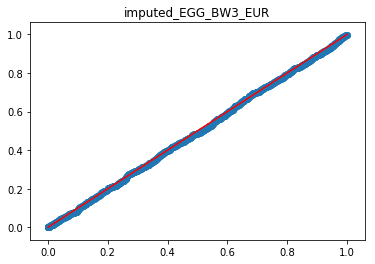

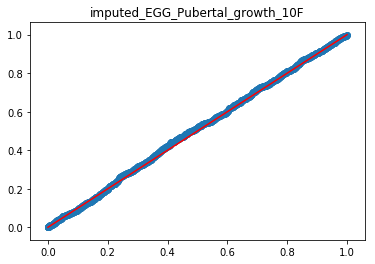

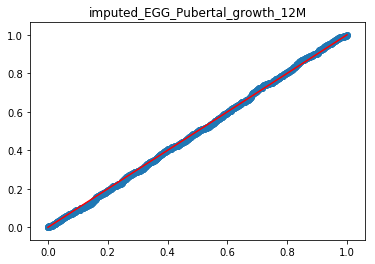

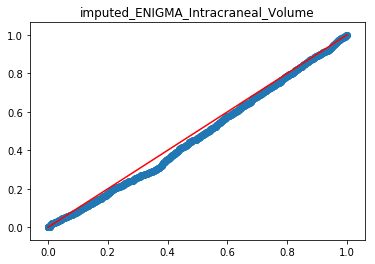

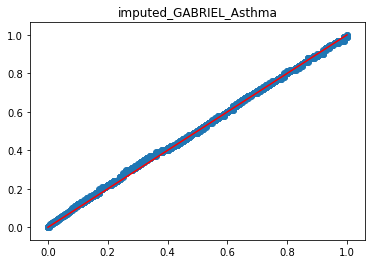

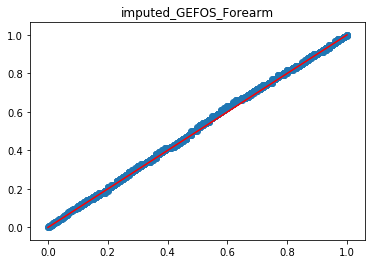

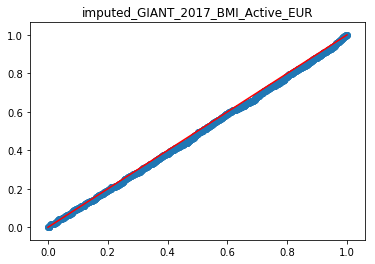

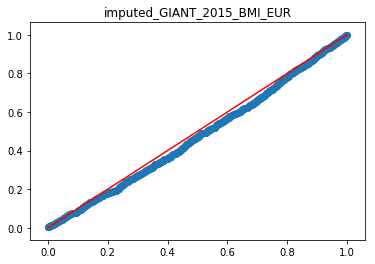

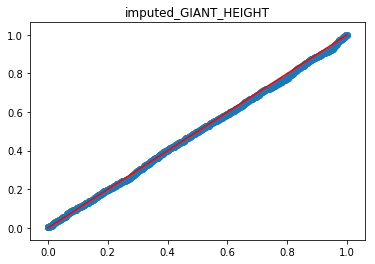

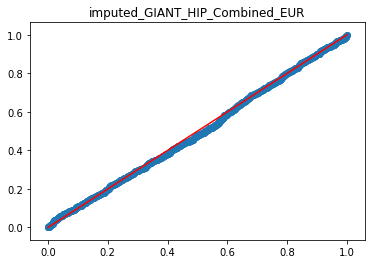

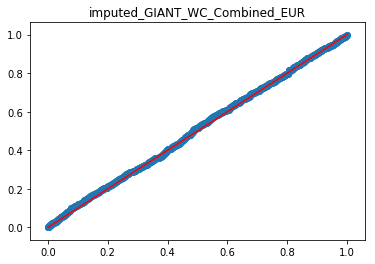

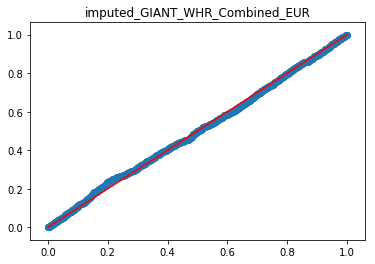

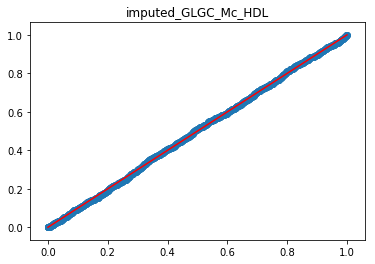

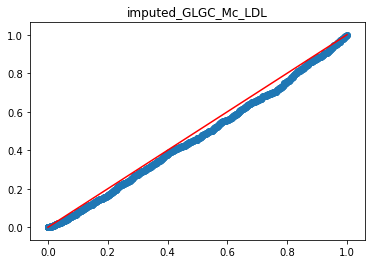

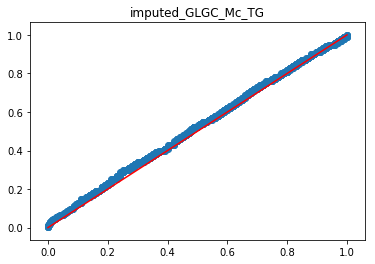

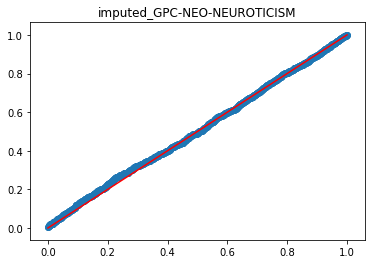

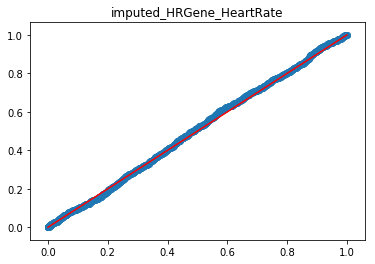

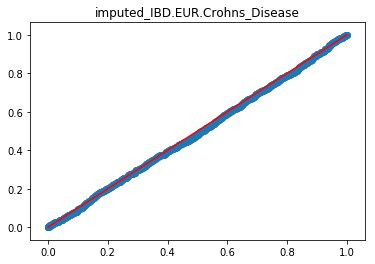

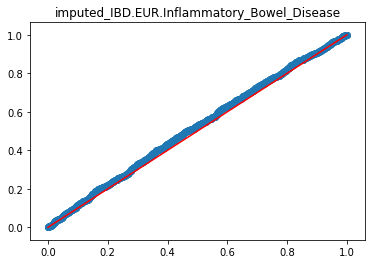

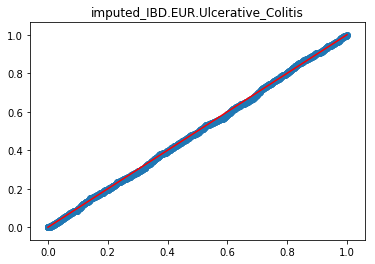

IndexError: index 87 is out of bounds for axis 1 with size 87

In [62]:
import matplotlib.pyplot as plt

for i in range(len(studies)):
    rand_vals = [x for x in rand_pval_res[:,i] if not np.isnan(x)]
    vals = [x for x in pval_res[:,i] if not np.isnan(x)]
#     plt.boxplot([np.log10(rand_vals), np.log10(vals)], labels=["random","trans-eqtls"])
    qqplot( rand_vals, vals )
    plt.title(studies[i])
    plt.show()


In [282]:
res_gwas_dict = dict()

res_file = "all_gwas_pvals_{:s}.tsv"
for tissue in tissuenames:
    # rsids, values, studies
    res_gwas_dict[tissue] = read_gwas_result(os.path.join(basepath_gwas_pvals, res_file.format(tissue)), tissue_eqtl_variant_ids_ld, tissue)

In [326]:
gwas_studycat = dict()
for tissue in tissuenames:
    cat_dict = collections.defaultdict(list)
    studies = res_gwas_dict[tissue][2]
    for study in studies:
        cat_dict[study_catg[study]] += list(studies[study][~np.isnan(studies[study])])
    gwas_studycat[tissue] = cat_dict

In [181]:
def read_rand_gwas_result(i):
    filepath = os.path.join(basepath_results, "gwas", "gwas_pvals", "random", "all_gwas_pvals_1000_{:05d}.tsv".format(i))
    rsids, matrix, studies = read_gwas_result(filepath)
    return studies

In [347]:
def sample_study_background(study, n_snps, cutoff):
    randtrans = list()
    if cutoff > 1000:
        cutoff = 1e-2 / (len(relevant_studies) * 1000)
    for i in np.arange(1, 11):
        rand_study_res = read_rand_gwas_result(i)[study]
        if n_snps < 1000:
            np.random.shuffle(rand_study_res)
            rand_study_res = rand_study_res[:n_snps]
        randtrans.append(np.sum(rand_study_res < cutoff))
    # Mean and std of each of the files
    return np.mean(randtrans), np.std(randtrans)

In [218]:
from os import walk
relevant_studies = list()
mypath = basepath_data + "GWAScatalog/imputed_gwas_hg38_1.1/relevant/"
for (dirpath, dirnames, files) in walk(mypath):
    for file in files:
        base_filename = file.replace(".tbi", "").replace(".txt.gz", "")
        if base_filename not in relevant_studies:
            relevant_studies.append(base_filename)

In [350]:
for tissue in tissuenames:
    n_snps_in_tissue = len(res_gwas_dict[tissue][0])
    cutoff = 1e-2 / (len(relevant_studies) * n_snps_in_tissue) if n_snps_in_tissue else 0
    print(n_snps_in_tissue)
    print("\n\n", tissuenames_dict[tissue], "\nstudy\tbackground\tfraction\tenrichment\tpval")
    for study in relevant_studies:
        study_res = res_gwas_dict[tissue][2][study]
        n_study_hits = np.sum(study_res < cutoff)
        
        study_bg = sample_study_background(study, n_snps_in_tissue, cutoff)[0] / n_snps_in_tissue
        
        frac_study_hits = n_study_hits / n_snps_in_tissue
        enrichment = frac_study_hits / study_bg if study_bg != 0  else 0
        pval = stat.binom_test(n_study_hits, n_snps_in_tissue, study_bg, alternative="greater")
        if n_study_hits > 0.0:
            print(study, study_bg, frac_study_hits, enrichment, pval)

477


 Adipose Subcutaneous 
study	background	fraction	enrichment	pval
imputed_Astle_et_al_2016_Red_blood_cell_count 0.0014675052410901466 0.0020964360587002098 1.4285714285714288 0.5036699399354466
imputed_Astle_et_al_2016_Reticulocyte_count 0.002306079664570231 0.0020964360587002098 0.9090909090909091 0.6675514930279983
imputed_Astle_et_al_2016_Lymphocyte_counts 0.002306079664570231 0.0020964360587002098 0.9090909090909091 0.6675514930279983
imputed_UKB_2395_4_Hair_or_balding_pattern_Pattern_4 0.0014675052410901466 0.0020964360587002098 1.4285714285714288 0.5036699399354466
imputed_UKB_20002_1111_self_reported_asthma 0.0010482180293501049 0.0020964360587002098 2.0 0.3936283746866944
imputed_Astle_et_al_2016_Eosinophil_counts 0.0037735849056603774 0.0020964360587002098 0.5555555555555556 0.8352629635085758
imputed_Astle_et_al_2016_High_light_scatter_reticulocyte_count 0.002306079664570231 0.0020964360587002098 0.9090909090909091 0.6675514930279983
imputed_UKB_6152_8_diagnosed_by_docto

imputed_UKB_23099_Body_fat_percentage 0.002383654937570942 0.00340522133938706 1.4285714285714286 0.35040076462239017
imputed_UKB_20002_1226_self_reported_hypothyroidism_or_myxoedema 0.0014755959137343927 0.00340522133938706 2.3076923076923075 0.14276838849633441
imputed_Astle_et_al_2016_Platelet_count 0.0020431328036322363 0.0011350737797956867 0.5555555555555555 0.8350052011999802
imputed_Astle_et_al_2016_Monocyte_count 0.002383654937570942 0.00681044267877412 2.857142857142857 0.02030503198597645
imputed_Astle_et_al_2016_Sum_neutrophil_eosinophil_counts 0.00170261066969353 0.0022701475595913734 1.3333333333333333 0.4423171748664924
imputed_UKB_20002_1225_self_reported_hyperthyroidism_or_thyrotoxicosis 0.001362088535754824 0.0011350737797956867 0.8333333333333334 0.6990520630070187
imputed_EAGLE_Eczema 0.00011350737797956867 0.0011350737797956867 10.0 0.09516771762423519
1094


 Artery Coronary 
study	background	fraction	enrichment	pval
imputed_Astle_et_al_2016_Red_blood_cell_count 0

KeyboardInterrupt: 

In [ ]:
for tissue in tissuenames[21:]:
    n_snps_in_tissue = len(res_gwas_dict[tissue][0])
    cutoff = 1e-2 / (len(relevant_studies) * n_snps_in_tissue) if n_snps_in_tissue else 0
    print(n_snps_in_tissue)
    if n_snps_in_tissue != 0:
        with open(os.path.join(basepath_results, "gwas", "enrichments", tissue + "_enrich.tsv"), "w") as fout:
            fout.write("study\tbackground\tfraction\tenrichment\tpval\n")
            for study in relevant_studies:
                study_res = res_gwas_dict[tissue][2][study]
                n_study_hits = np.sum(study_res < cutoff)

                study_bg = sample_study_background(study, n_snps_in_tissue, cutoff)[0] / n_snps_in_tissue
                frac_study_hits = n_study_hits / n_snps_in_tissue
                enrichment = frac_study_hits / study_bg if study_bg != 0  else 0
                pval = stat.binom_test(n_study_hits, n_snps_in_tissue, study_bg, alternative="greater")
                fout.write(study + "\t" + str(study_bg) + "\t" +  str(frac_study_hits) + "\t" + 
                           str(enrichment) + "\t" + str(pval) + "\n")

153
59
778
12
6
14
0
186
8
27
327
3
1524
587
0
5


In [365]:
for tissue in tissuenames:
    backgrounds = dict()
    fractions = dict()
    enrichments = dict()
    pvals = dict()
    with open(os.path.join(basepath_results, "gwas", "enrichments", tissue + "_enrich.tsv")) as fin:
        next(fin)
        for line in fin:
            arr = line.strip().split("\t")
            study = arr[0]
            background = float(arr[1])
            fraction = float(arr[2])
            enrichment = float(arr[3])
            pval = float(arr[4])
            if study_catg[study] in backgrounds:
                backgrounds[study_catg[study]].append(background)
                fractions[study_catg[study]].append(fraction)
                enrichments[study_catg[study]].append(enrichment)
                pvals[study_catg[study]].append(pval)
            else:
                backgrounds[study_catg[study]] = [background]
                fractions[study_catg[study]] = [fraction]
                enrichments[study_catg[study]] = [enrichment]
                pvals[study_catg[study]] = [pval]
    print("\n", tissuenames_dict[tissue])
    for study in backgrounds:
        print(study, np.mean(backgrounds[study]), np.mean(fractions[study]), np.mean(enrichments[study]), np.mean(pvals[study]))


 Adipose Subcutaneous
Immune 0.0005690326445043426 0.0001497454327643007 0.17857142857142858 0.9521280307189633
Blood 0.0023360287511230904 0.0008984725965858042 0.4037635297033794 0.8616390377577172
Cardiometabolic 0.00011979634621144054 0.0 0.0 1.0
Psychiatric-neurologic 0.000209643605870021 0.0 0.0 1.0
Skeletal system disease 0.00010482180293501049 0.0 0.0 1.0
Hair morphology 0.0006289308176100629 0.0006988120195667366 0.4761904761904763 0.834556646645149
Allergy 0.0004891684136967156 0.0006988120195667366 0.8333333333333334 0.7765974766884954
Anthropometric 0.0029874213836477985 0.0 0.0 1.0
Cancer 0.0007686932215234102 0.0 0.0 1.0
Aging 0.0 0.0 0.0 1.0
Digestive system disease 0.0 0.0 0.0 1.0
Endocrine system 0.0012578616352201257 0.0 0.0 1.0

 Adipose Visceral Omentum
Immune 0.0005213764337851929 0.0010427528675703858 2.1428571428571423 0.8587242295306151
Blood 0.0020072992700729928 0.0020855057351407713 1.1394557823129252 0.7298114099862725
Cardiometabolic 0.00020855057351407719


 Brain Substantia nigra
Immune 0.0009523809523809525 0.0 0.0 1.0
Blood 0.002857142857142857 0.0 0.0 1.0
Cardiometabolic 0.00047619047619047624 0.0 0.0 1.0
Psychiatric-neurologic 0.0009523809523809524 0.0 0.0 1.0
Skeletal system disease 0.0 0.0 0.0 1.0
Hair morphology 0.0022222222222222222 0.0 0.0 1.0
Allergy 0.0 0.0 0.0 1.0
Anthropometric 0.008333333333333333 0.0 0.0 1.0
Cancer 0.0 0.0 0.0 1.0
Aging 0.0 0.0 0.0 1.0
Digestive system disease 0.0 0.0 0.0 1.0
Endocrine system 0.0033333333333333335 0.0 0.0 1.0

 Breast Mammary Tissue
Immune 0.00054608999563128 0.00043687199650502403 0.380952380952381 0.9037846549203373
Blood 0.002315421581476628 0.0015290519877675843 0.5503663003663003 0.8068367641873263
Cardiometabolic 0.00017474879860200962 0.00021843599825251202 0.17857142857142855 0.9521317186001931
Psychiatric-neurologic 0.00020387359836901125 0.000145623998835008 0.15873015873015875 0.9647277991501413
Skeletal system disease 0.00030581039755351685 0.0 0.0 1.0
Hair morphology 0.000611

FileNotFoundError: [Errno 2] No such file or directory: '/home/kira/eqtls/results/gwas/enrichments/fib_enrich.tsv'

In [353]:
study_catg

{'imputed_UKB_1160_Sleep_duration': 'Psychiatric-neurologic',
 'imputed_UKB_1180_Morning_or_evening_person_chronotype': 'Psychiatric-neurologic',
 'imputed_UKB_1200_Sleeplessness_or_insomnia': 'Psychiatric-neurologic',
 'imputed_UKB_1807_Fathers_age_at_death': 'Aging',
 'imputed_UKB_20002_1094_self_reported_deep_venous_thrombosis_dvt': 'Cardiometabolic',
 'imputed_UKB_20002_1111_self_reported_asthma': 'Allergy',
 'imputed_UKB_20002_1154_self_reported_irritable_bowel_syndrome': 'Digestive system disease',
 'imputed_UKB_20002_1222_self_reported_type_1_diabetes': 'Immune',
 'imputed_UKB_20002_1223_self_reported_type_2_diabetes': 'Cardiometabolic',
 'imputed_UKB_20002_1225_self_reported_hyperthyroidism_or_thyrotoxicosis': 'Endocrine system',
 'imputed_UKB_20002_1226_self_reported_hypothyroidism_or_myxoedema': 'Endocrine system',
 'imputed_UKB_20002_1243_self_reported_psychological_or_psychiatric_problem': 'Psychiatric-neurologic',
 'imputed_UKB_20002_1261_self_reported_multiple_sclerosis':

## Pval plots

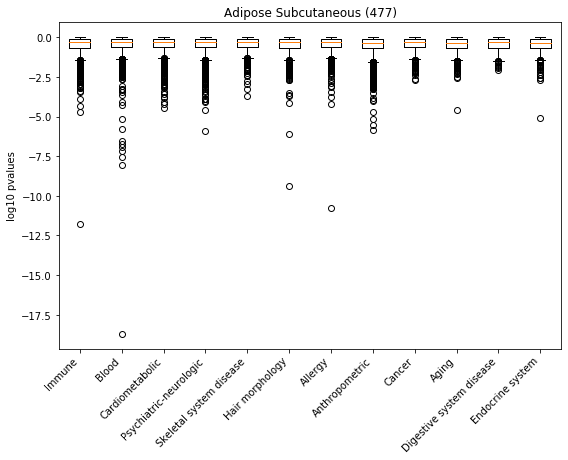

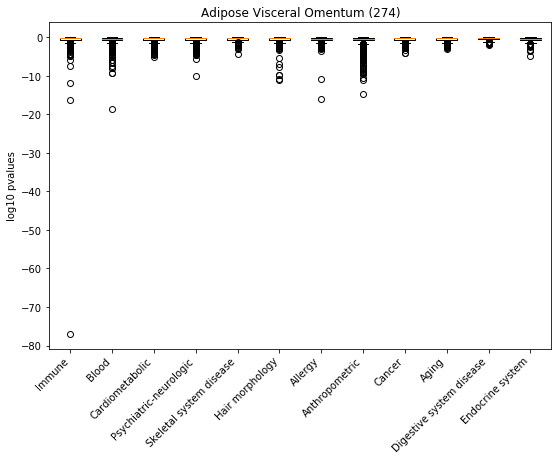

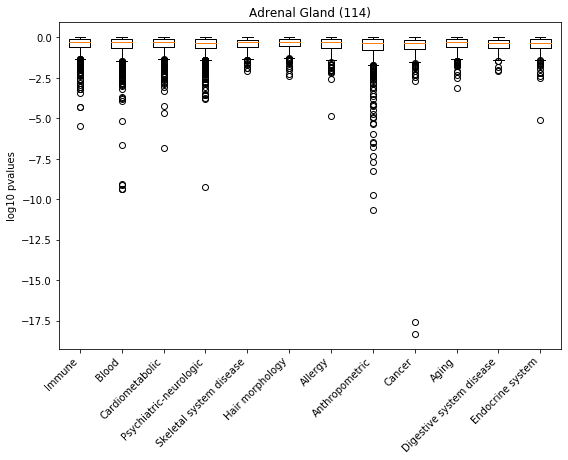

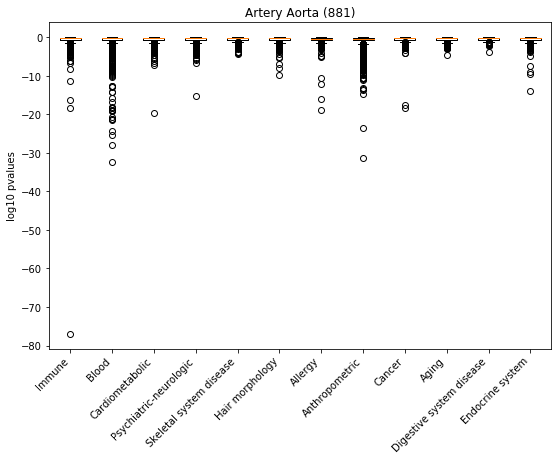

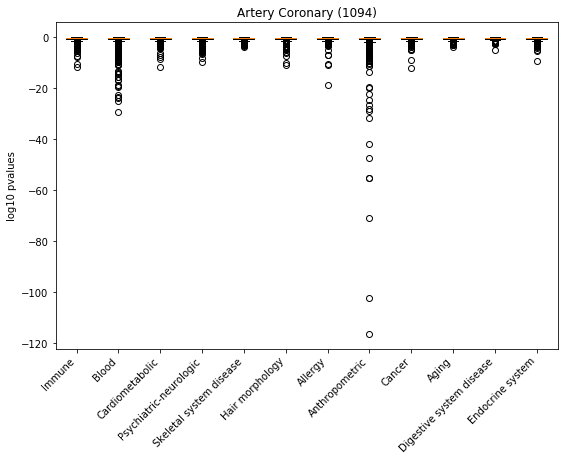

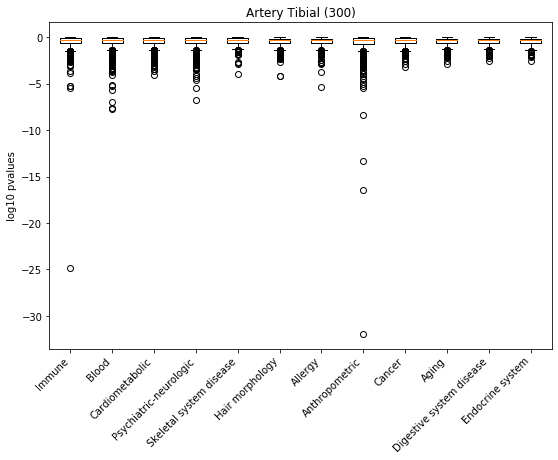

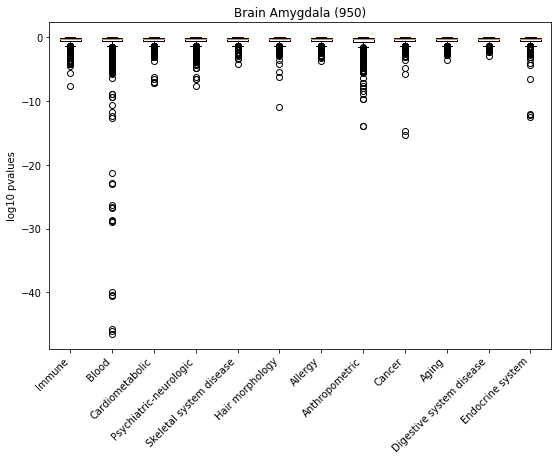

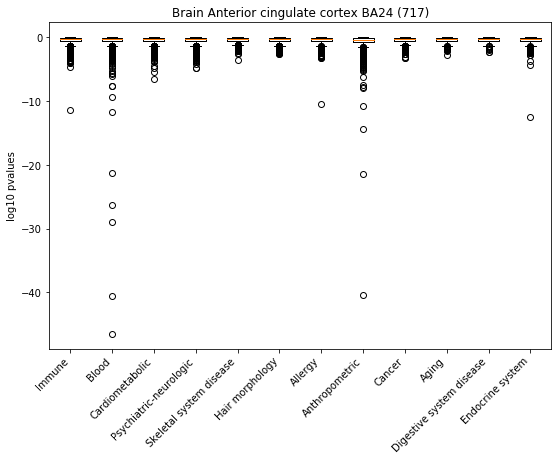

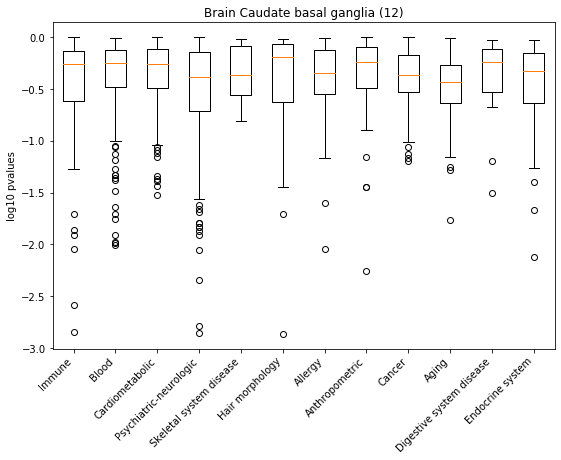

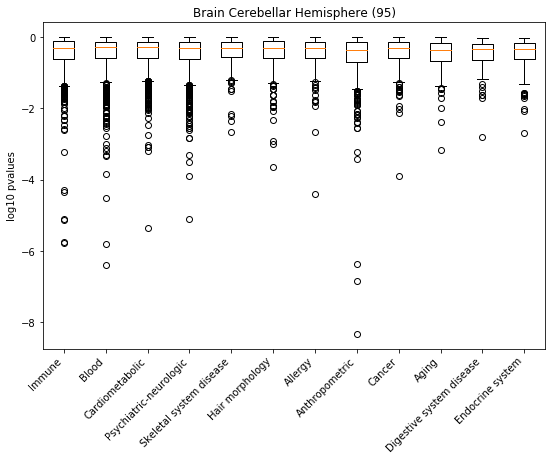

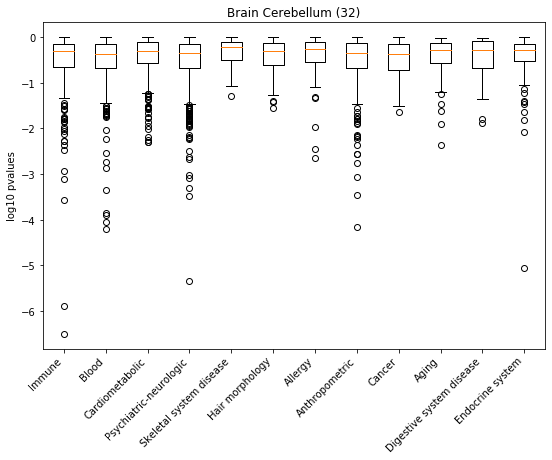

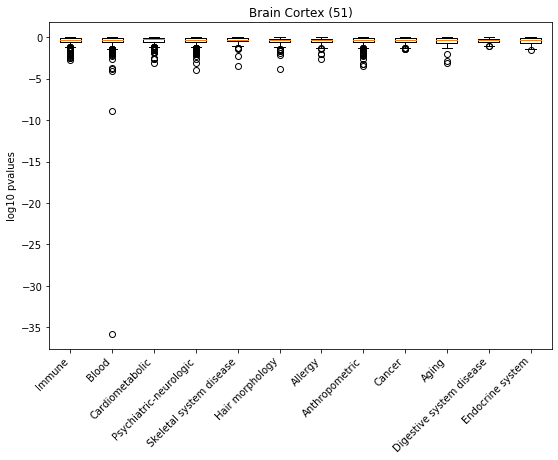

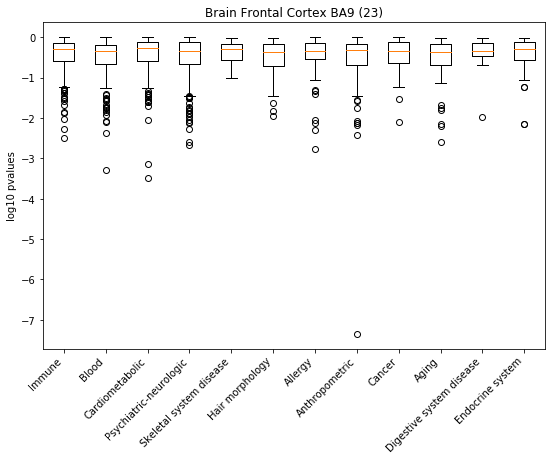

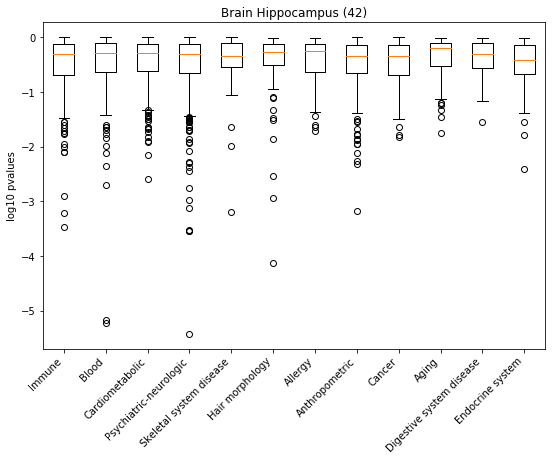

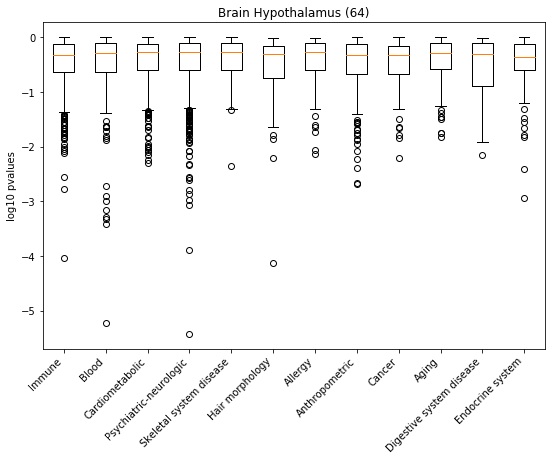

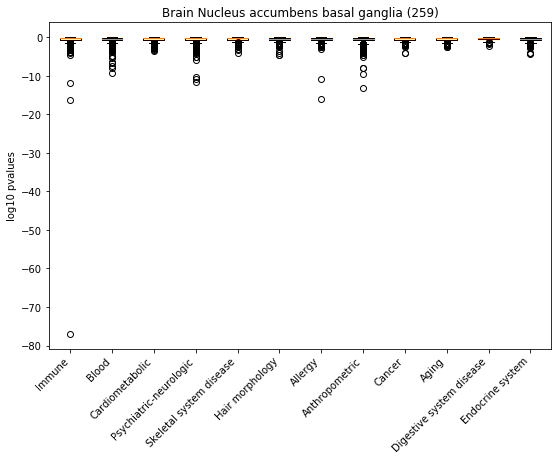

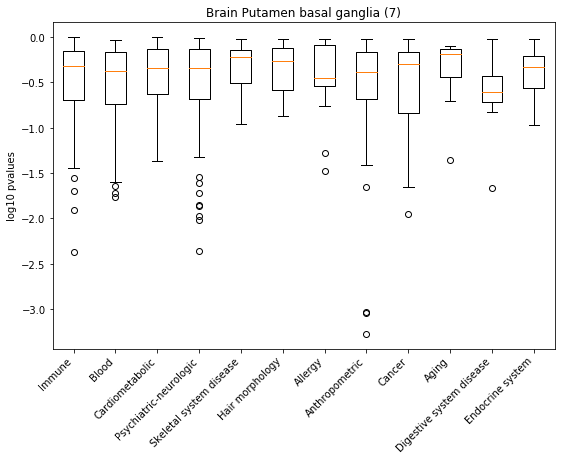

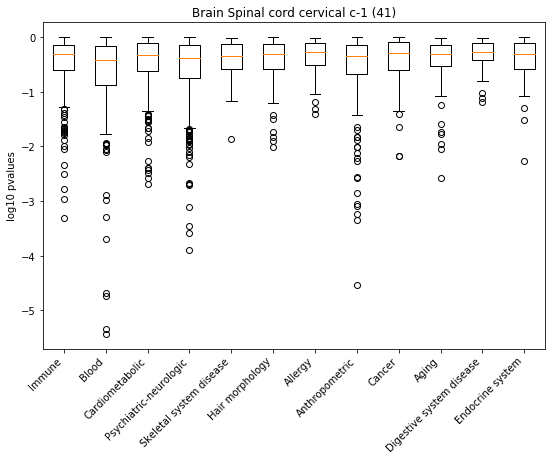

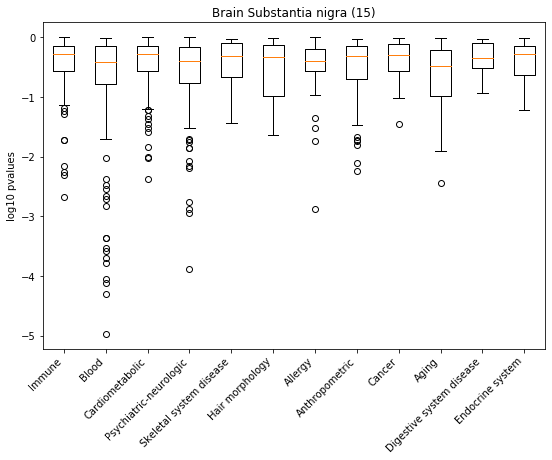

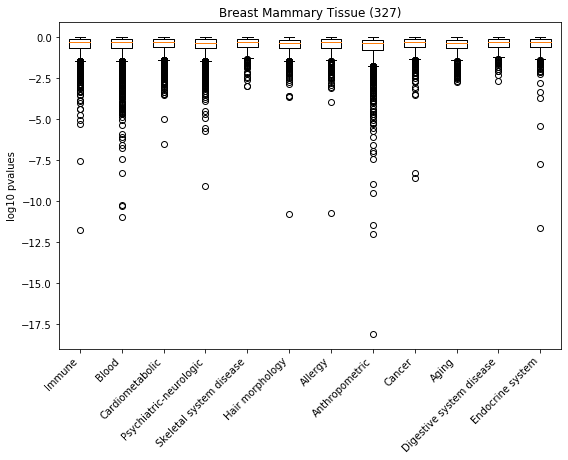

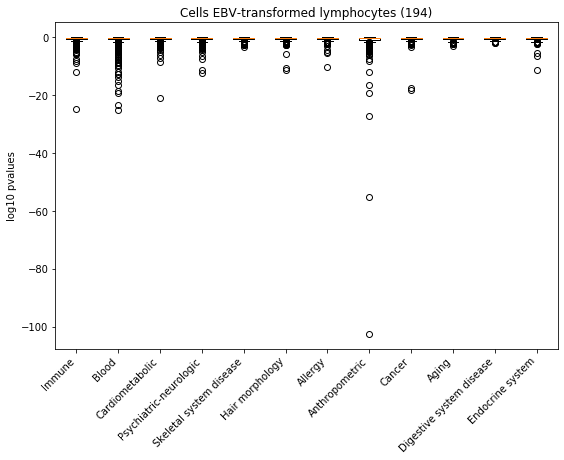

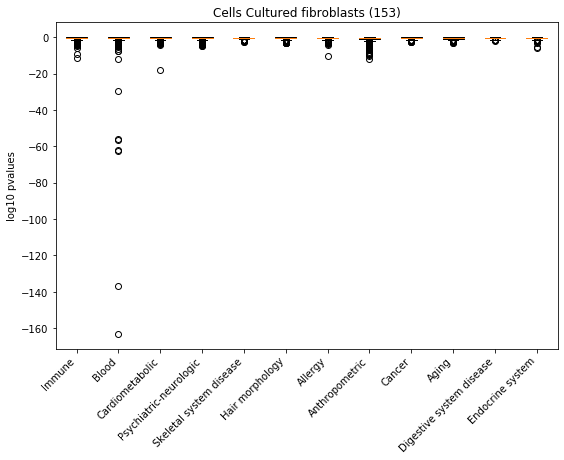

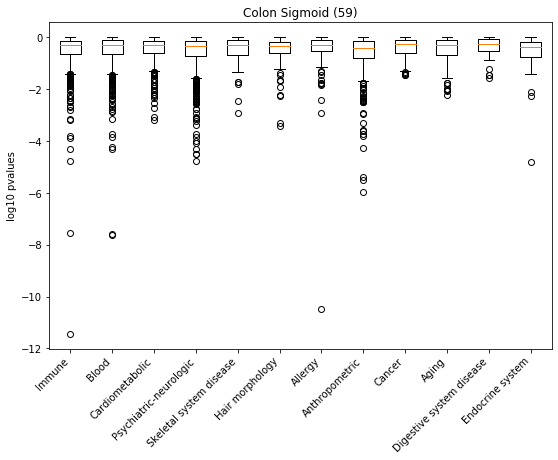

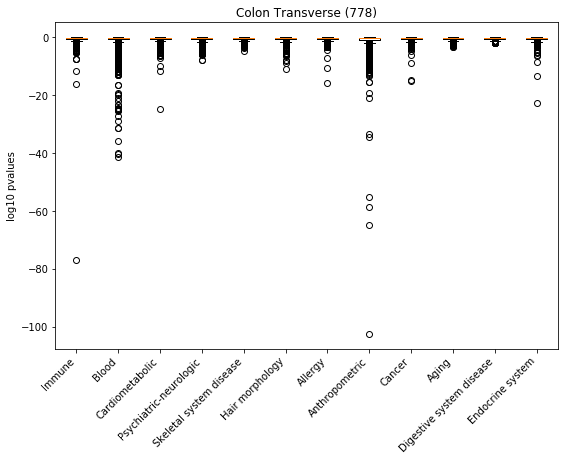

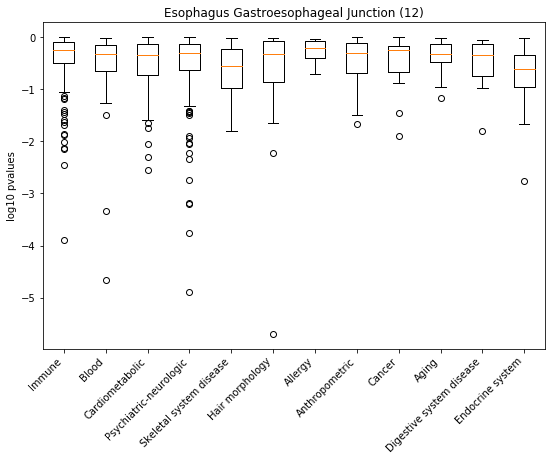

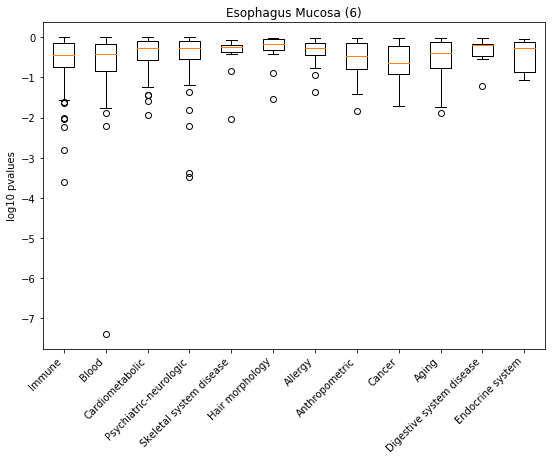

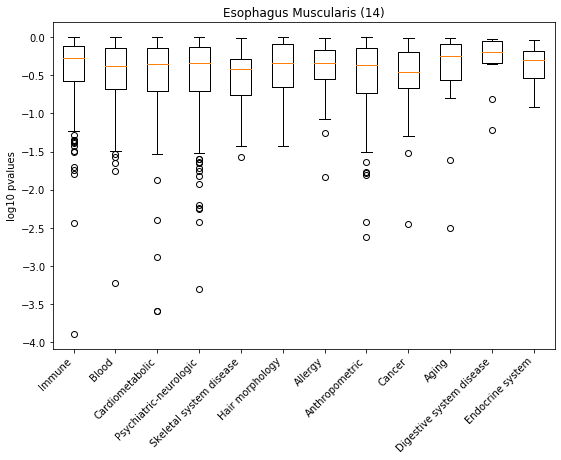

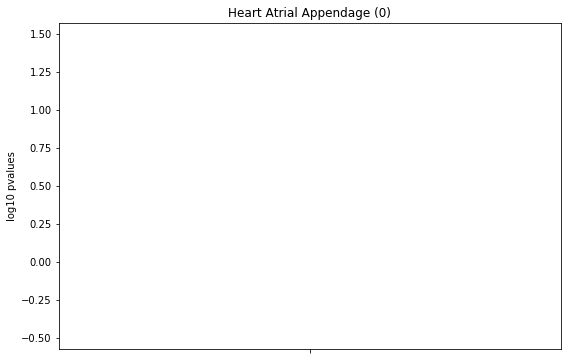

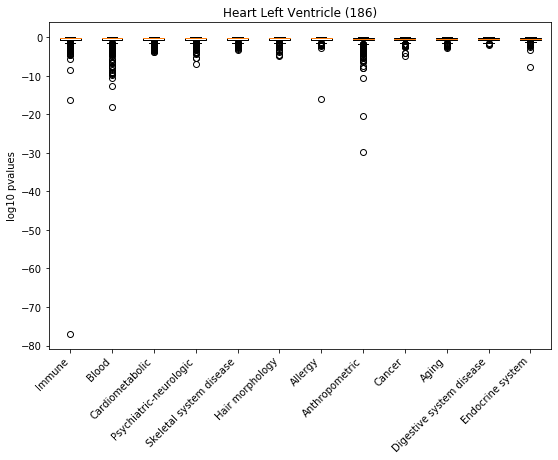

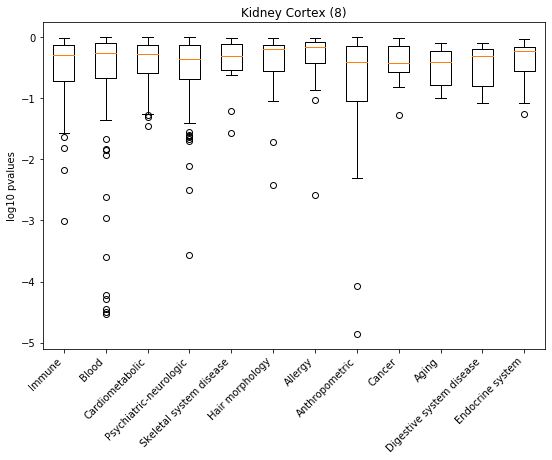

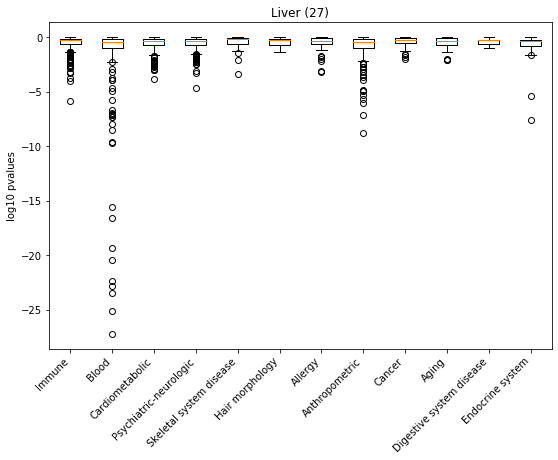

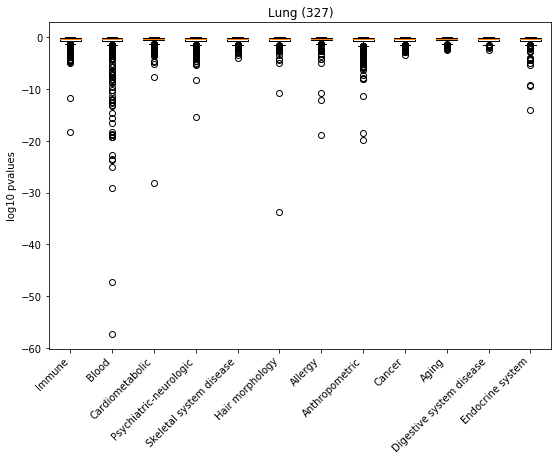

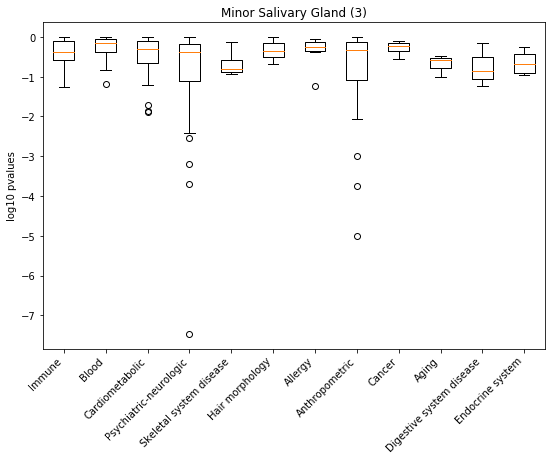

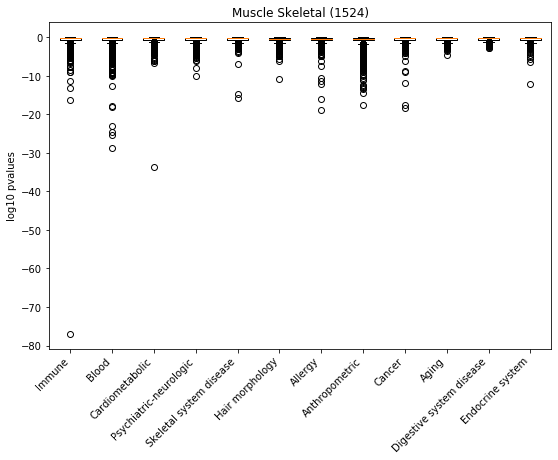

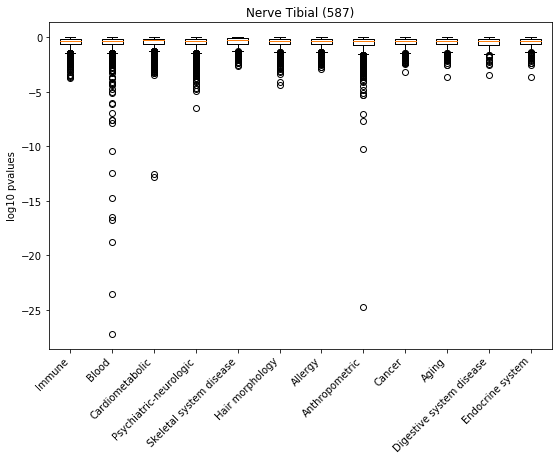

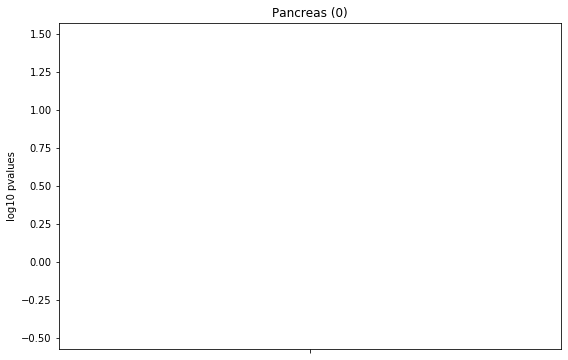

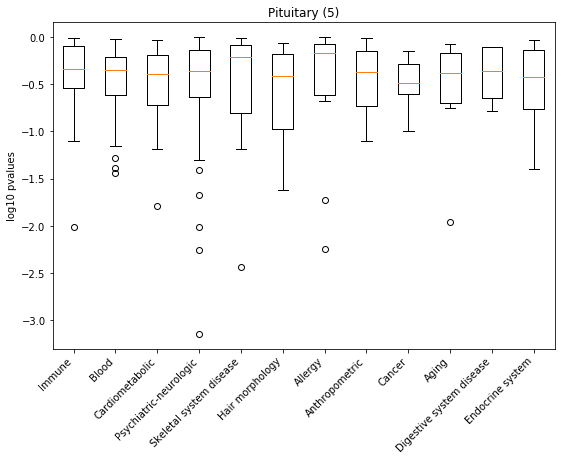

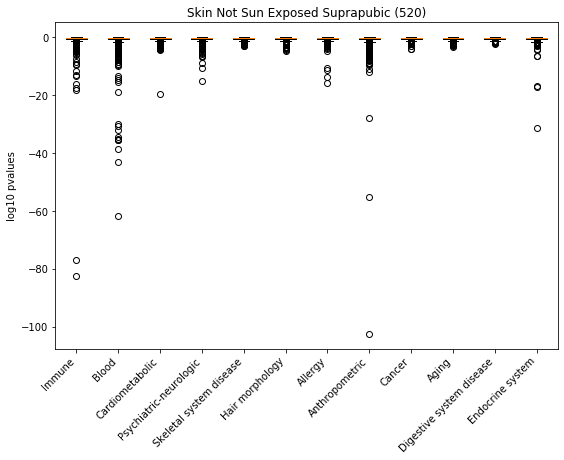

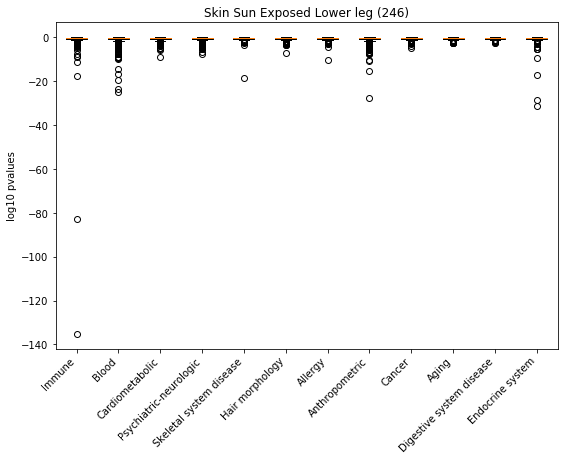

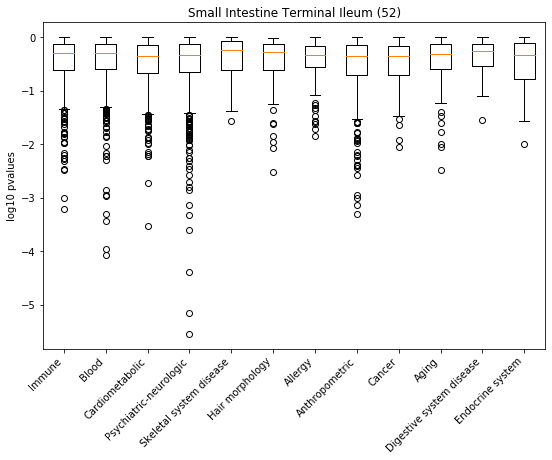

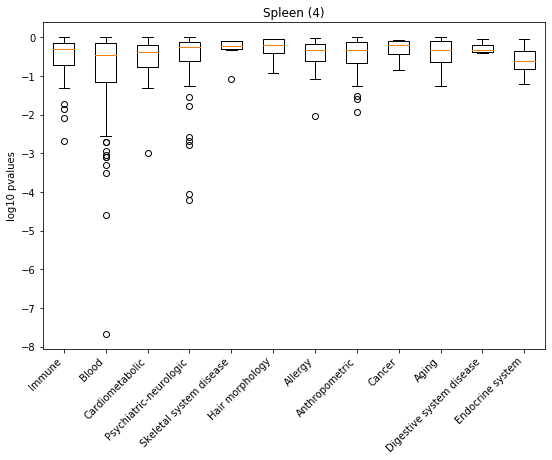

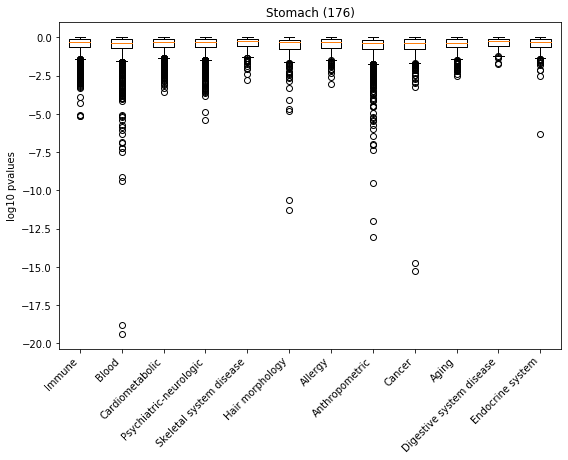

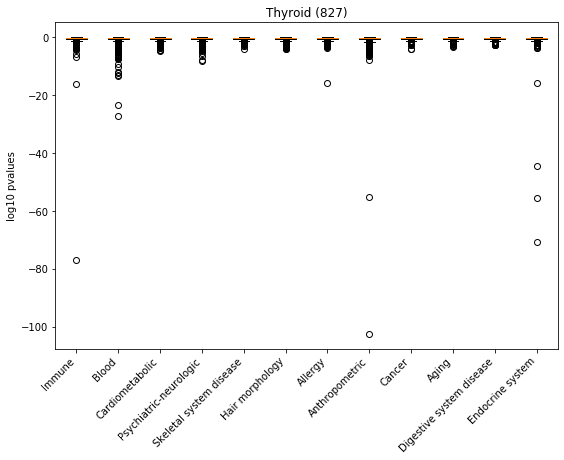

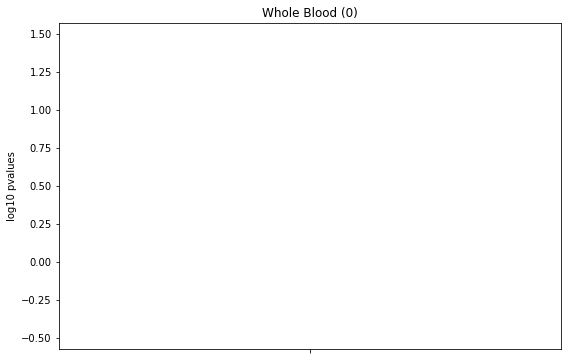

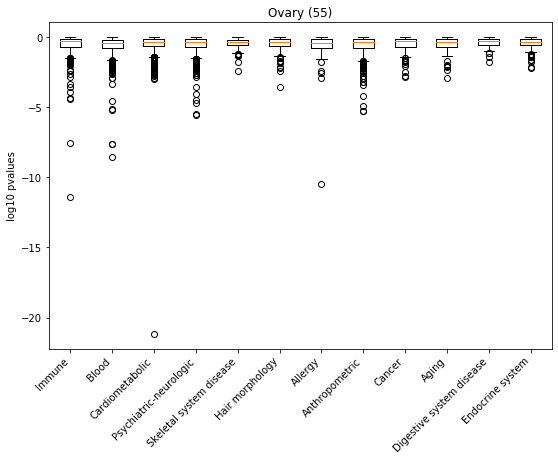

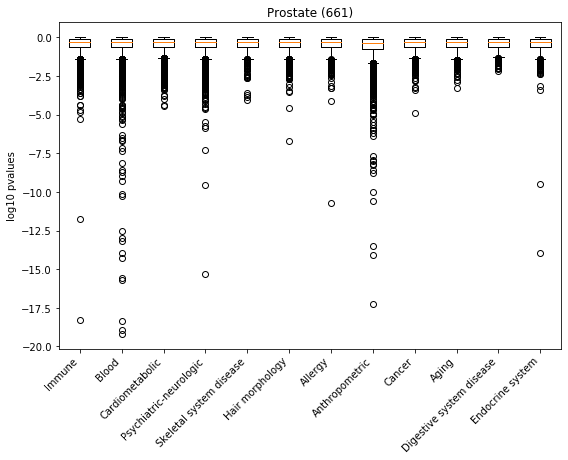

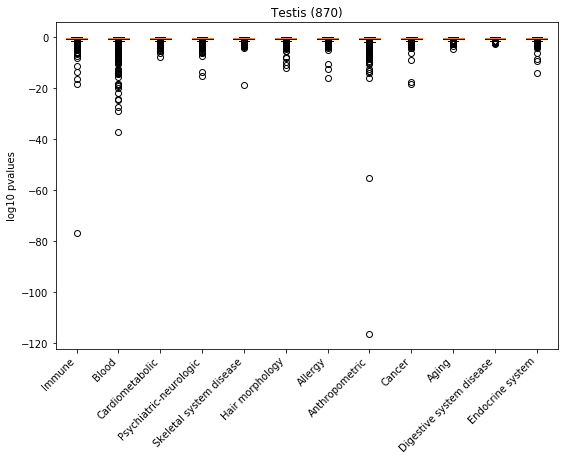

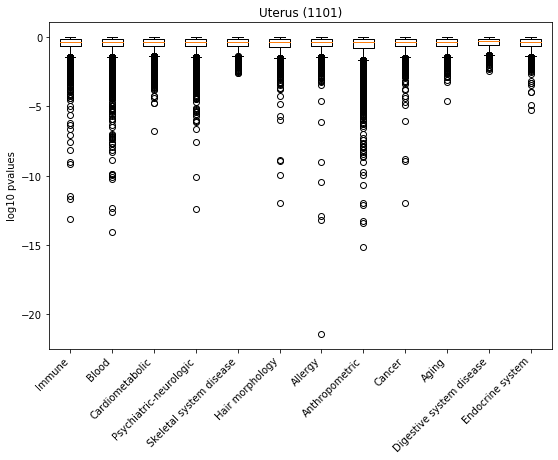

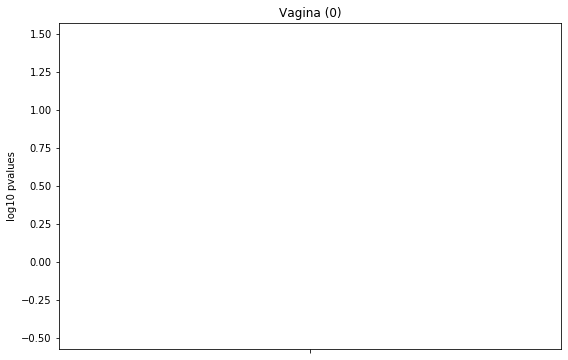

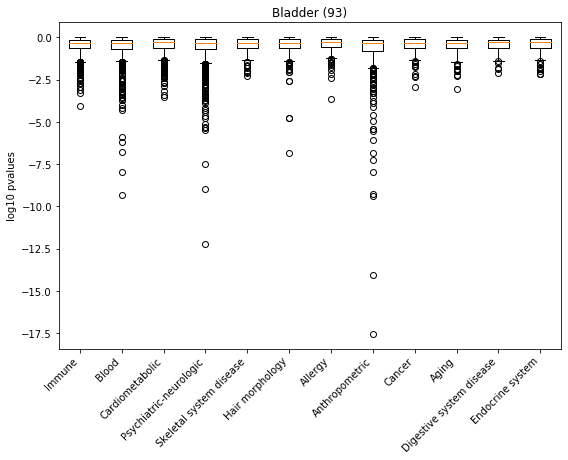

In [327]:
for tissue in tissuenames:
    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(111)
    ax1.boxplot([np.log10(gwas_studycat[tissue][study]) for study in gwas_studycat[tissue]])
    ax1.set_xticklabels(list(gwas_studycat[tissue].keys()), ha="right", rotation=45)
    ax1.set_title(tissuenames_dict[tissue] + " ({:d})".format(len(res_gwas_dict[tissue][0])))
    ax1.set_ylabel("log10 pvalues")
    plt.show()

# Creating Pval files

In [164]:
filepaths = [basepath_data + "GWAScatalog/imputed_gwas_hg38_1.1/relevant/" + studie + ".txt.gz" for studie in studies]
for nid in ["{:05d}".format(x) for x in np.arange(500, 501)]:
    Nrand = "1000"
    randomfile = "/home/kira/eqtls/datasets/vcfs_0.01/random_sampling_ids/random_" + Nrand + "_" + nid
    rand_ids = list()
    # Getting list of all dbsnp ids that are in the file
    for chrom in chromlist:
        with open(os.path.join(randomfile, "chr{:s}.txt".format(str(chrom)))) as fin:
        # All variant_ids in the file
            rand_ids += [line.rstrip() for line in fin]
    all_pvals = get_array_all_pvals(filepaths, rand_ids)
    with open(basepath_results + "gwas_pvals/random/all_gwas_pvals_" +  Nrand + "_" + nid + ".tsv", "w") as fout:
        fout.write("variant_id\t" + "\t".join(studies) + "\n")
        for variant_counter in np.arange(len(rand_ids)):
            variant_id = rand_ids[variant_counter]
            fout.write(variant_id + "\t")
            for study_counter in range(len(studies)):
                fout.write(str(all_pvals[variant_counter][study_counter]) +  "\t")
            fout.write("\n")

In [308]:
filepaths = [basepath_data + "GWAScatalog/imputed_gwas_hg38_1.1/relevant/" + studie + ".txt.gz" for studie in studies]
for nid in ["{:05d}".format(x) for x in np.arange(1, 2)]:
    Nrand = "10000"
    randomfile = "/home/kira/eqtls/datasets/vcfs_0.01/random_sampling_ids/random_" + Nrand + "_" + nid
    rand_ids = list()
    # Getting list of all dbsnp ids that are in the file
    for chrom in chromlist:
        with open(os.path.join(randomfile, "chr{:s}.txt".format(str(chrom)))) as fin:
        # All variant_ids in the file
            rand_ids += [line.rstrip() for line in fin]
    all_pvals = get_array_all_pvals(filepaths, rand_ids)
    with open(basepath_results + "gwas_pvals/random/all_gwas_pvals_" +  Nrand + "_" + nid + ".tsv", "w") as fout:
        fout.write("variant_id\t" + "\t".join(studies) + "\n")
        for variant_counter in np.arange(len(rand_ids)):
            variant_id = rand_ids[variant_counter]
            fout.write(variant_id + "\t")
            for study_counter in range(len(studies)):
                fout.write(str(all_pvals[variant_counter][study_counter]) +  "\t")
            fout.write("\n")

KeyboardInterrupt: 